# Checking BURs

## Import dependencies

In [1]:
from src import utils
import numpy as np
import pandas as pd
from src.features.rhythm_features import BeatUpbeatRatio
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import json
import os
from pretty_midi import PrettyMIDI
import scipy.stats as stats
import src.visualise.visualise_utils as vutils
import matplotlib as mpl
from datetime import datetime
import librosa
from src.detect.onset_utils import OnsetMaker
import soundfile as sf

In [2]:
INSTRS = ['piano', 'bass']

In [3]:
res = {}

## Get automatic annotation BURs

In [4]:
corp = utils.load_corpus_from_files(f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

In [20]:
res['jtd_auto_piano'] = []
res['jtd_auto_bass'] = []
for track in corp:  
    if not track.item['has_annotations']:
        continue
    for instr in INSTRS:
        my_beats = track.summary_dict[instr]
        my_onsets = track.ons[instr]
        feat = BeatUpbeatRatio(my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True)
        burs = feat.bur_log['burs'].dropna().to_list()
        res[f'jtd_auto_{instr}'].extend(burs)

## Get manual annotations BURs

In [6]:
cm = utils.CorpusMaker.from_excel('corpus_updated', only_30_corpus=False, only_annotated=True)

In [7]:
res['jtd_manual_piano'] = []
res['jtd_manual_bass'] = []
dnv = dict(
    left=1/32,
    right=1/16
)
for track in cm.tracks:
    beats = np.loadtxt(f'{utils.get_project_root()}/references/manual_annotation/{track["fname"]}_mix.txt', usecols=0)
    om = OnsetMaker(item=track, skip_processing=True)
    om.tempo = np.mean(60 / np.diff(beats))
    for instr in INSTRS:
        my_onsets = np.loadtxt(f'{utils.get_project_root()}/references/manual_annotation/{track["fname"]}_{instr}.txt', usecols=0)
        my_beats = om.match_onsets_and_beats(beats=beats, onsets=my_onsets, detection_note_values=dnv)        
        feat = BeatUpbeatRatio(my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True)
        burs = feat.bur_log['burs'].dropna().to_list()
        res[f'jtd_manual_{instr}'].extend(burs)

## Get Weimar Jazz Database (piano only) BURs

In [8]:
wjdfpath = f'{utils.get_project_root()}/wjazz.db'

In [ ]:
!wget -O {wjdfpath} https://jazzomat.hfm-weimar.de/download/downloads/wjazzd.db

In [9]:
cnx = sqlite3.connect(wjdfpath)

In [10]:
beatsdf = pd.read_sql_query("SELECT * FROM beats", cnx)
meldf = pd.read_sql_query("SELECT * FROM melody", cnx)
metadf = pd.read_sql_query("SELECT * FROM solo_info", cnx)

In [11]:
pnoids = metadf[metadf['instrument'] == 'p']['melid'].values

In [12]:
res['wjd_piano'] = []
dur = 0 
for pid in pnoids:
    # Extract the average tempo from the metadata database
    tempo = metadf[metadf['melid'] == pid]['avgtempo'].iloc[0]
    # Extract the beats and piano onsets
    beats_wjd = beatsdf[beatsdf['melid'] == pid]['onset'].values
    my_onsets_wjd = meldf[meldf['melid'] == pid]['onset'].values
    dur += (max(beats_wjd) - min(beats_wjd))
    # Match the beat annotations with the nearest onsets in the piano
    omwjd = OnsetMaker(cm.tracks[0], skip_processing=True)
    omwjd.tempo = tempo
    my_beats_wjd = omwjd.match_onsets_and_beats(beats=beats_wjd, onsets=my_onsets_wjd) 
    # Extract the beat upbeat ratios
    feat = BeatUpbeatRatio(my_onsets=my_onsets_wjd, my_beats=my_beats_wjd, clean_outliers=True)
    burs = feat.bur_log['burs'].dropna().to_list()
    res['wjd_piano'].extend(burs)

## Get Filobass (bass only) BURs

In [13]:
fbpath = f'{utils.get_project_root()}/filobass.zip'
fbfolder = f'{utils.get_project_root()}/filobass'

In [ ]:
!wget -O {fbpath} https://github.com/aim-qmul/FiloBass/releases/download/v1.0.0/FiloBass_v1.0.0.zip

In [ ]:
!mkdir -p {fbfolder}
!unzip -o -qq {fbpath} -d {fbfolder}

In [14]:
# Get names of all tracks
tracks = set(f.replace('.json', '') for f in os.listdir(f'{utils.get_project_root()}/filobass/FiloBass ISMIR Publication/syncpoints'))

In [15]:
# Iterate through each track
res['fb_bass'] = []
skiptracks = 0
meantemps = []
for track in tracks:
    # Load the MusicXML
    a = open(f'{utils.get_project_root()}/filobass/FiloBass ISMIR Publication/musicxml/{track}.xml', 'r').readlines()
    # Skip tracks not tagged as swing
    if not any('Swing' in l for l in a):
        skiptracks += 1
        continue
    # Get the time signature by iterating through the XML
    timesig = int([i for i in a if "<beats>" in i][0].split('>')[1].split('<')[0])
    # Open up the syncpoints and get only the downbeats
    syncpoints = json.load(open(f'{utils.get_project_root()}/filobass/FiloBass ISMIR Publication/syncpoints/{track}.json', 'r'))
    downbeats = np.array([i[1] for i in syncpoints])
    # We don't have beat-level information, so interpolate enough beats between each downbeat to approximate this
    beats_fb = np.concatenate([np.linspace(i1, i2, timesig, endpoint=False) for i1, i2 in zip(downbeats, downbeats[1:])])
    tempo = np.mean(60 / np.diff(beats_fb))
    # If the tempo isn't in range, then skip
    if not 100 <= tempo <= 300:
        skiptracks += 1
        continue
    meantemps.append(tempo)
    # Extract the onsets from the MIDI (conversion to set removes duplicates)
    midi = PrettyMIDI(f'{utils.get_project_root()}/filobass/FiloBass ISMIR Publication/midi_fully_aligned/{track}.mid')
    my_onsets_fb = np.array(sorted(set(i.start for i in midi.instruments[0].notes)))
    # Match the beat annotations with the nearest onsets in the bass
    omfb = OnsetMaker(cm.tracks[0], skip_processing=True)
    omfb.tempo = tempo
    my_beats_fb = omfb.match_onsets_and_beats(beats=beats_fb, onsets=my_onsets_fb)   
    # Create the feature extractor
    feat = BeatUpbeatRatio(my_onsets=my_onsets_fb, my_beats=my_beats_fb, clean_outliers=True)
    burs = feat.bur_log['burs'].dropna().to_list()
    res['fb_bass'].extend(burs)

## Putting it all together

In [16]:
def kde(data, len_data: int = 1000) -> tuple:
    """Fit the KDE to the data and evaluate on a list of y-values, then scale"""
    # Fit the actual KDE to the data, using the default parameters
    kde = stats.gaussian_kde(data.T)
    # Create a linear space of integers ranging from our lowest to our highest BUR
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    # Evaluate the KDE on our linear space of integers
    y = kde.evaluate(data_plot.T)
    return data_plot, np.array([(y_ - min(y)) / (max(y) - min(y)) for y_ in y])

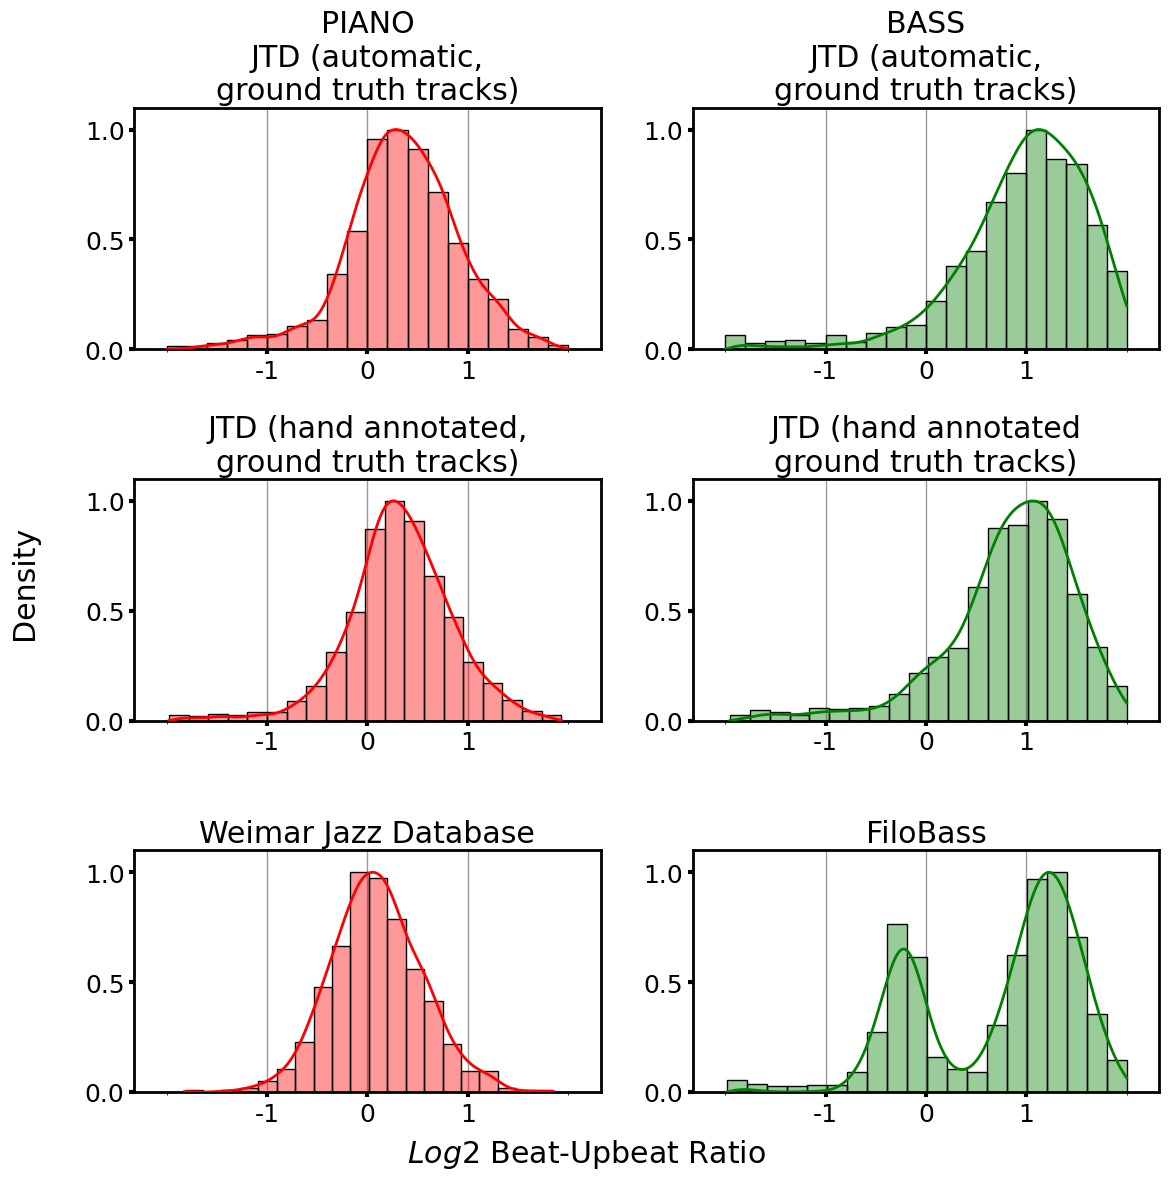

In [24]:
titles = [
    'PIANO\nJTD (automatic,\nground truth tracks)', 'BASS\nJTD (automatic,\nground truth tracks)',
    'JTD (hand annotated,\nground truth tracks)', 'JTD (hand annotated\nground truth tracks)', 
    'Weimar Jazz Database', 'FiloBass'
]
HIST_KWS = dict(lw=vutils.LINEWIDTH / 2, ls=vutils.LINESTYLE, zorder=2, align='edge')
KDE_KWS = dict(linestyle=vutils.LINESTYLE, alpha=1, zorder=3, linewidth=vutils.LINEWIDTH)

plt.rcParams.update({'font.size': vutils.FONTSIZE})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for a, tit, (k, v) in zip(ax.flatten(), titles, res.items()):
    v = np.array(v)
    c = 'red' if 'piano' in k else 'green'
    # Create the histogram
    heights, edges = np.histogram(v, bins=20)
    heights = heights / max(heights)
    # Plot the normalized histogram
    HIST_KWS.update(dict(x=edges[:-1], height=heights, width=np.diff(edges)))
    a.bar(fc=c, edgecolor='None', alpha=vutils.ALPHA, **HIST_KWS)
    a.bar(fc='None', edgecolor=vutils.BLACK, alpha=1, **HIST_KWS)
    a.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    a.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    # Plot the kde
    x, y = kde(v)
    a.set_xscale('symlog', base=2)
    a.plot(x, y, color=c, **KDE_KWS)
    a.set(
        title=tit, ylabel='', xlim=(-2.5, 2.5), ylim=(0, 1.1), 
        xticks=[-1, 0, 1], xticklabels=[-1, 0, 1],
    )
    a.grid(zorder=0, axis='x', **vutils.GRID_KWS)
    plt.setp(a.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
    a.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
fig.supylabel('Density')
fig.supxlabel('$Log$2 Beat-Upbeat Ratio')
fig.tight_layout()
fig.subplots_adjust(bottom=0.075)
fig.savefig(f'{utils.get_project_root()}/reports/figures/for_reviewers/bur_comparison.png')
plt.show()

In [25]:
for k, v in res.items():
    print(k, len([i for i in v if i < 0]) / len(v), len(v), np.mean(np.exp(v)))

jtd_auto_piano 0.22012732615083253 4084 1.6466116970181128
jtd_auto_bass 0.08502340093603744 1282 3.0629388229083947
jtd_manual_piano 0.23060517195414557 3751 1.5781635447779672
jtd_manual_bass 0.10379550735863671 1291 2.7114799105550924
wjd_piano 0.4229137199434229 707 1.2250224529268439
fb_bass 0.3014294592914854 3218 2.599992574253047


## Audiate negative BUR examples

In [19]:
tohear = 0
pad = np.zeros(utils.SAMPLE_RATE)
audio = {'bass': [], 'piano': []}
for track in corp:  
    for instr in ['piano']:
        # Extract beats and onsets for this instrument
        my_beats = track.summary_dict[instr]
        my_onsets = track.ons[instr]
        # Extract beat upbeat ratios
        feat = BeatUpbeatRatio(my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True)
        burdf = feat.bur_log
        burs = burdf['burs']
        # Set BUR > 0 to nan
        negs = np.where(burs >= 0, np.nan, burs) 
        # Split into groups of 4 consecutive negative BURs
        grps = [negs[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(negs))]
        neg5 = [grp for grp in grps if len(grp) == 4]
        # If we don't have any groups, skip this track
        if len(neg5) == 0:
            continue
        # Get the indexes for each group
        split = [(idx, np.array((i1, i2, i3, i4))) for idx, (i1, i2, i3, i4) in enumerate(zip(negs, negs[1:], negs[2:], negs[3:]))]
        timestamps = []
        for grp in neg5:
            for idx, sp in split:
                if np.array_equal(sp, grp):
                    # Get the start and stop timestamps
                    sub = (burdf.iloc[idx: idx + 5]['beat'] - datetime(1970, 1, 1)).dt.total_seconds()
                    timestamps.append((min(sub), max(sub)))
        tohear += len(timestamps)
        # Load the audio at this point
        try:
            co = f"-{track.item['channel_overrides'][instr]}chan"
        except KeyError:
            co = ''
        y, _ = librosa.load(f'{utils.get_project_root()}/data/processed/mvsep_audio/{track.item["fname"]}{co}_{instr}.wav', sr=utils.SAMPLE_RATE, mono=True, dtype=np.float64)
        # Iterate through each timestamp
        for start, stop in timestamps:
            start_sp = int(start * utils.SAMPLE_RATE)
            stop_sp = int(stop * utils.SAMPLE_RATE)
            trunc = np.concatenate((y[start_sp:stop_sp], pad))
            audio[instr].extend(trunc)   
tohear

192

In [20]:
with open(f'{utils.get_project_root()}/piano_burs.wav', 'wb') as fp:
    sf.write(fp, audio['piano'], utils.SAMPLE_RATE)

## Get information from Dittmar et al., 2018 WJD tracks

In [23]:
dittmar_ids = [1, 2, 4, 32, 34, 39, 40, 43, 59, 69, 72, 82, 83, 92, 99, 100, 102, 103, 127, 129, 137, 138, 141, 143, 144, 146, 157, 161, 162, 167, 169, 172, 175, 177, 180, 182, 192, 198, 201, 202, 216, 237, 238, 239, 245, 261, 266, 269, 273, 293, 298, 310, 313, 319, 323, 325, 326, 328, 331, 337, 340, 344, 345, 346, 347, 352, 355]
dur = 0
for did in dittmar_ids:
    dit_beats_wjd = beatsdf[beatsdf['melid'] == did]['onset'].values
    dur += (max(dit_beats_wjd) - min(dit_beats_wjd))
print(dur)

6505.696609977324
